In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir='/fd1/QibinShi_data/England_farm/'

### data

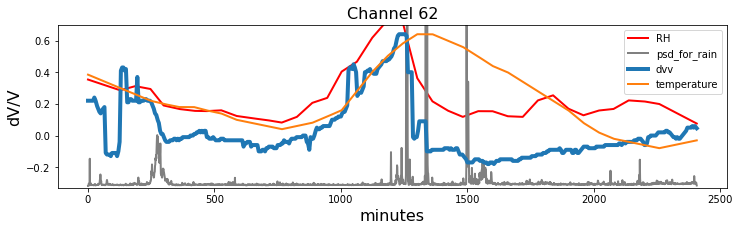

In [6]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    psd = f['psd_rain'][:]
    temp = f['temperature'][:]

s=moisture/100*2-1
    
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), 1-s, label='RH', color='r', lw=2)
plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
plt.ylim(-0.33, 0.7)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

,Plot,Treatments,tillage,Depth (cm),Dry Bulk density (g/cm3),Porosity (%),Moisture content (%),Rock volume (%),ind
0,1,STP Deep,25,10,1.29,51.28,13.61,2.36,35.0
3,2,LTP Deep,25,10,1.31,50.47,13.02,2.27,34.0
6,3,CTF Zero,0,10,1.22,53.98,14.56,3.55,33.0
9,4,CTF Zero,25,10,1.29,51.22,12.12,1.62,32.0
12,5,LTP Shallow,10,10,1.53,42.21,13.13,1.15,31.0


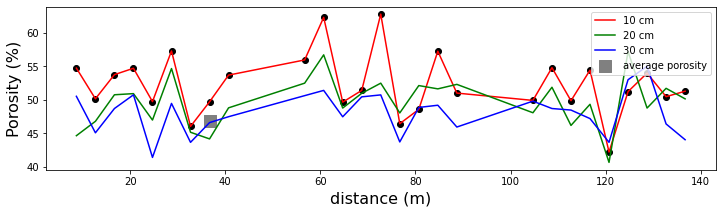

In [4]:
## read the soil physical parameters at different plots
phy_paras = pd.read_csv(data_dir + 'Soil_phy.csv')

## reverse the plot number, adding spare plots
phy_paras.loc[phy_paras['Plot'].between(1,9), 'ind'] = 36 - phy_paras.loc[phy_paras['Plot'].between(1,9), 'Plot']
phy_paras.loc[phy_paras['Plot'].between(10,18), 'ind'] = 33 - phy_paras.loc[phy_paras['Plot'].between(10,18), 'Plot']
phy_paras.loc[phy_paras['Plot'].between(19,27), 'ind'] = 30 - phy_paras.loc[phy_paras['Plot'].between(19,27), 'Plot']
phy_paras = phy_paras.loc[phy_paras['Plot'] < 28]

## split the data into different depths
phy_10cm = phy_paras.loc[phy_paras['Depth (cm)'] == 10]
phy_20cm = phy_paras.loc[phy_paras['Depth (cm)'] == 20]
phy_30cm = phy_paras.loc[phy_paras['Depth (cm)'] == 30]

## locate the plot near channel 62
plot_ind_for_ch62 = np.round((3.19 * 12 + 3.3) / 4 ).astype(int)
bulk_density_10cm = phy_10cm.loc[phy_10cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
bulk_density_20cm = phy_20cm.loc[phy_20cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
bulk_density_30cm = phy_30cm.loc[phy_30cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
porosity_10cm = phy_10cm.loc[phy_10cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100
porosity_20cm = phy_20cm.loc[phy_20cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100
porosity_30cm = phy_30cm.loc[phy_30cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100

bulk_density = (bulk_density_10cm+bulk_density_20cm+bulk_density_30cm)/3
porosity = (porosity_10cm+porosity_20cm+porosity_30cm)/3

## plot the porosity at different depths, plots and near the channel 62
plt.figure(figsize=(12, 3))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), color='k')
plt.scatter(plot_ind_for_ch62*4-3.3, porosity * 100, color='gray', s=150, marker='s', label='average porosity')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Porosity (%)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Porosity (%)']), label='30 cm', color='b')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Porosity (%)", fontsize = 16)
plt.legend() 

phy_10cm.head()

### Hydrological model

In [16]:
class hydro:
    def __init__(self, prec, porosity, s, T, I, till, tire, A_p, A_e, A_d):
        self.prec = prec
        self.s = s  ## Saturation (water / (air + water))
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d

        ## evaporation
        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239
        self.pet = 1.6 * np.power((10*self.T / self.I), self.a)
        self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

        ## drainage
        self.drain = self.prec * self.s * self.till * self.tire  ## Drainage rate



    def get_s_rate(self):

        return self.A_p * self.prec - self.A_e * self.evap - self.A_d * self.drain

### the evaporation slope

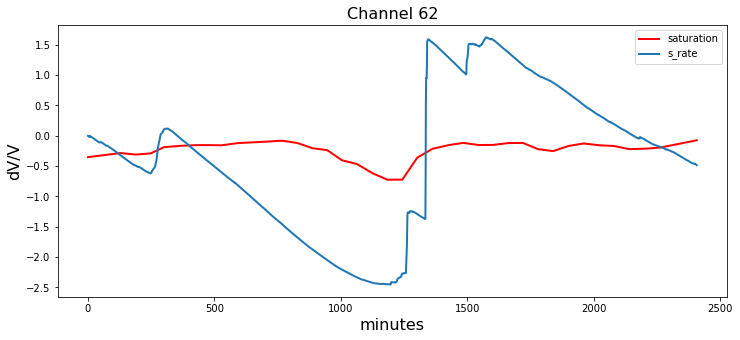

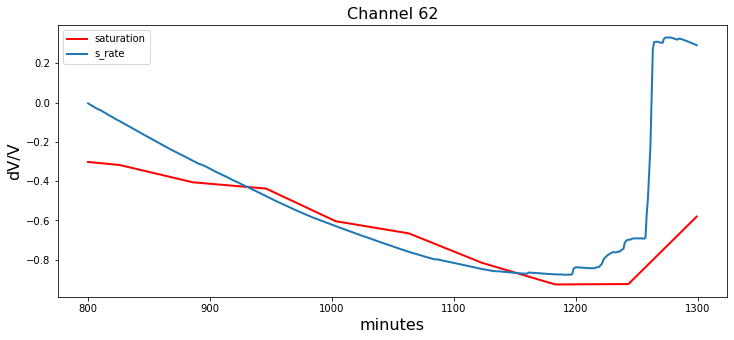

In [122]:
s_rate = hydro(psd, porosity, s, temp, 12, 25, 7, 2,0.000005,0.0005).get_s_rate()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(2408), s-1, label='saturation', color='r', lw=2)
plt.plot(np.arange(2408), np.cumsum(s_rate), label='s_rate', lw=2)
# plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
# plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
# plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
# plt.ylim(-1, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(500)+800, s[800:1300]-1.2, label='saturation', color='r', lw=2)
plt.plot(np.arange(500)+800, np.cumsum(s_rate[800:1300]), label='s_rate', lw=2)
# plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
# plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
# plt.plot(np.arange(len(temp)), (temp-8)/5, label='temperature', lw=2)
# plt.ylim(-1, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()